# PySpice_EyePoint_CurveTracer
## часть проекта по восстановлению электронной схемы характериографом
### генерация базы сигналов с разных схем для последующего обучения модели

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

import PySpice
import PySpice.Logging.Logging as Logging

from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Doc.ExampleTools import find_libraries

from PySpice.Unit import *
import sys
import os
import uuid
import random

logger = Logging.setup_logging()
PySpice.show_version()


FILEBASE_ROOT = 'E:\EyePoint'
if not os.path.exists(FILEBASE_ROOT):
    os.makedirs(FILEBASE_ROOT)

print('simulation dataset on:\n'+FILEBASE_ROOT)

libraries_path = os.path.join(FILEBASE_ROOT,'spice_library')
print('spice models library on:\n'+libraries_path)
spice_library = SpiceLibrary(libraries_path)
print(spice_library['1N4148'])



PySpice Version 1.4.3
simulation dataset on:
E:\EyePoint
spice models library on:
E:\EyePoint\spice_library
E:\EyePoint\spice_library\diode\switching\1N4148.lib


### код CreateCVC базируется на библиотеке MySpice
https://github.com/LukyanovM/MySpice

используем эту библиотеку, ибо она максимально близко имитирует прибор

In [2]:
import math
import numpy

class CurveTracer_Settings():
    """ EyePoint hardware settings struct"""
    def __init__(self,F=10_000,V=3.3,Rcs=0,SNR=40.0,lendata=50,cycle=1):
        self.F = F
        self.V = V
        self.Rcs = Rcs
        self.SNR = SNR
        self.lendata = lendata
        self.cycle = cycle
    
    def to_numpy(self):
        arr = np.array([self.F, self.V, self.Rcs, self.SNR, self.lendata, self.cycle])
        return arr
    
    def from_numpy(self,arr):
        self.F = arr[0]
        self.V = arr[1]
        self.Rcs = arr[2]
        self.SNR = arr[3]
        self.lendata = arr[4]
        self.cycle = arr[5]
    
ct_default_settings = CurveTracer_Settings()

def plot_analysis_IV(analysis,ax=None):
    """ plot I(V) curve for analysis """
    if ax is None:
        plt.grid()
        plt.plot(analysis.input_dummy, analysis.VCurrent)
        plt.title('I(V)')
        plt.xlabel('Напряжение [В]')
        plt.ylabel('Сила тока [А]')
        return
    ax.grid()
    ax.plot(analysis.input_dummy, analysis.VCurrent)
    ax.set_title('I(V)')
    ax.set_xlabel('Напряжение [В]')
    ax.set_ylabel('Сила тока [А]')
    

def CreateCVC(circuit,ct=ct_default_settings):
    cycle = ct.cycle
    lendata = ct.lendata
    period = 1 / ct.F
    rms_voltage = ct.V / math.sqrt(2)
    # добавляем испытательный щуп в схему
    circuit.R('cs', 'input', 'input_dummy', ct.Rcs)
    circuit.AcLine('Current', circuit.gnd, 'input_dummy', rms_voltage=rms_voltage, frequency=ct.F)
    
    simulator = circuit.simulator()
    analysis = simulator.transient(step_time=period / lendata, end_time=period * cycle)
    analysis.input_dummy = analysis.input_dummy[len(analysis.input_dummy)-lendata:len(analysis.input_dummy)]
    analysis.VCurrent = analysis.VCurrent[len(analysis.VCurrent)-lendata:len(analysis.VCurrent)]
# Расчитываем шум независмо для тока и напряжения исходя из среднеквадратичных значений и одинакового SNR
    avg_V_db = 10 * numpy.log10(numpy.mean(numpy.array(analysis.input_dummy, dtype=float) ** 2))
    avg_Vnoise_db = avg_V_db - ct.SNR
    Vnoise = numpy.random.normal(0, numpy.sqrt(10 ** (avg_Vnoise_db / 10)), len(analysis.input_dummy))
    analysis.input_dummy = numpy.array(analysis.input_dummy, dtype=float) + Vnoise
    avg_I_db = 10 * numpy.log10(numpy.mean(numpy.array(analysis.VCurrent, dtype=float) ** 2))
    avg_Inoise_db = avg_I_db - ct.SNR
    Inoise = numpy.random.normal(0, numpy.sqrt(10 ** (avg_Inoise_db / 10)), len(analysis.VCurrent))
    analysis.VCurrent = numpy.array(analysis.VCurrent, dtype=float) + Inoise
    # удаляем испытательный щуп из схемы
    circuit.Rcs.detach()
    circuit.VCurrent.detach()
    return analysis


#### пример использования CreateCVC

2022-01-26 14:40:43,839 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - spinit was not found
2022-01-26 14:40:43,839 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: can't find init file.


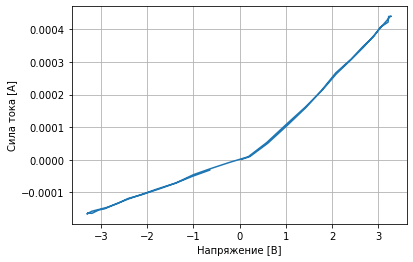

Wall time: 2.01 s


In [3]:
%%time
circuit = Circuit('RD')
circuit.include(spice_library['1N4148'])
circuit.R(1,'input',1,10@u_kOhm)
circuit.X('D1', '1N4148', 1, circuit.gnd)
circuit.R(2,'input',circuit.gnd,20@u_kOhm)

analysis = CreateCVC(circuit)
        
plt.grid()
plt.plot(analysis.input_dummy, analysis.VCurrent)
plt.xlabel('Напряжение [В]')
plt.ylabel('Сила тока [А]')
plt.show()



### как построена база?
каждой схеме соответствует папка, в которой хранятся файлы массивов симуляции c номиналами схемы и параметрами прибора,и circuit файл - информация о самой схеме

In [4]:
%%time
def save_cir_analysis(fileName,circuit_params,curve_params,analysis):
    """ save circuit nominals,curve tracer parameters, voltage and current arrays to file"""
    with open(fileName, 'wb') as f:
        np.save(f,circuit_params)
        np.save(f,curve_params)
        np.save(f,analysis.VCurrent)
        np.save(f,analysis.input_dummy)
    
def make_sure_path(path_title):
    """ create path if path not exist, return full path """
    dirName = os.path.join(FILEBASE_ROOT,path_title)
    if not os.path.exists(dirName):
        os.makedirs(dirName)
    return dirName

def save_circuit(dirName,circuit):
    """ save sample circuit on disk """
    fileName = os.path.join(dirName,circuit.title+'.cir')
    with open(fileName,'w') as f:
        f.write(str(circuit))
        

Wall time: 0 ns


In [5]:
def load_circuit_dataset(path_dataset,ct_settings=None,shuffle=True,max_files=None):
    """ load dataset from circuit folder.
    return X,y """
    fileList = [f for f in os.listdir(path_dataset) if f.endswith('.npy')]
    
    if shuffle: 
        random.shuffle(fileList)
        
    if max_files is not None:
        max_files = min(max_files,len(fileList))
        fileList=fileList[0:max_files]
    
    X_data,y_data=[],[]
    
    for fileName in tqdm(fileList): # process files
        with open(os.path.join(path_dataset,fileName), 'rb') as f:
            circuit_params = np.load(f)
            curve_params = np.load(f)
            VCurrent = np.load(f)
            input_dummy = np.load(f)
            
            if ct_settings is not None: 
                ct = CurveTracer_Settings().from_numpy(curve_params)
                F_ok = math.abs(ct_settings.F-ct.F) < 0.1
                V_ok = math.abs(ct_settings.V-ct.V) < 0.05
                if (F_ok and V_ok)==False:
                    continue
                    
                len_ok = ct_settings.lendata == ct.lendata
                cyc_ok = ct_settings.cycle == ct.cycle
                if (len_ok and cyc_ok)==False:
                    continue
                    
                #Rcs_ok = math.abs(ct_settings.Rcs-ct.Rcs) < 1
                #SNR_ok = True #math.abs(ct_settings.SNR-ct.SNR) < 1
        
        # append data to arrays
        y_data.append(circuit_params)
        X_data.append([VCurrent,input_dummy])
        
    return np.array(X_data),np.array(y_data)

## базовый класс схем

In [17]:
import pickle
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,LassoCV,RidgeCV,ElasticNetCV
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.multioutput import MultiOutputRegressor


class BaseCircuitModel():
    """ base class for circuit models. Provide training, data preprocessing,
    prediction for nominal values """
    def __init__(self,title='baseAbstract',modelDir=None,modelName=None):
        self.title = title
        self.modelDir = os.path.join(FILEBASE_ROOT,self.title) if (modelDir is None) else modelDir  
        make_sure_path(self.modelDir)
        self.modelName = title+'.pickle' if (modelName is None) else modelName   
        self.modelFileName = os.path.join(self.modelDir,self.modelName)
        self.optimize_save_flag = False
        
        try:
            self.load_model()
        except OSError as e:
            print(e)
            print('rebuild model ...')
            self.rebuild_model()
        
    
    def load_model(self):
        with open(self.modelFileName, "rb") as f:
                self.model = pickle.load(f)
                self.rank = self.model.rank # number of circuit variative nominals
    
    def save_model(self):
        with open(self.modelFileName, "wb") as f:
                self.model.rank = self.rank
                pickle.dump(self.model, f)
        
        
    def write_dataset(self,Xvals):
        """ circuit batch simulation over params Xvals"""
        for xval in tqdm(Xvals): # walk over nominals in circuit and create I/V curves
            #print(xval)
            cir_params = np.array(xval)
            circuit = self.build_circuit(cir_params)
            analysis = CreateCVC(circuit)
            fileName = os.path.join(self.modelDir,uuid.uuid4().hex+'.npy')
            save_cir_analysis(fileName,cir_params,ct_default_settings.to_numpy(),analysis)

    def load_dataset(self):
        """ load dataset from disk. Can be overwritten for feature construction"""
        X_data,y_data = load_circuit_dataset(self.modelDir)
        ADim = X_data.shape[0]
        X_data = X_data.reshape(ADim,-1)
        if self.rank==1: # fit shape 1d regression or Nd regression 
            y_data = y_data.reshape(-1)
        else:
            y_data = y_data.reshape(ADim,-1)
            
        return X_data,y_data
        
    def build_model(self,estimator=None, save_model=True, test_model=True ): 
        print('dataset for model '+self.title+' is loading, please wait..')
        if estimator is None:
            if self.rank>1:
                self.model = MultiOutputRegressor(GradientBoostingRegressor())
            else:
                self.model = GradientBoostingRegressor()
        else:
            self.model = estimator
        
        X_data,y_data = self.load_dataset()
        #print(X_data.shape)
        #print(y_data.shape)   
        print('model '+self.title+' is training, please wait..')
        self.model.fit(X_data,y_data)
        self.model.rank = self.rank
        
        if save_model:
            self.save_model()
            self.load_model()
        
        if test_model:
            print('test_model() routine for '+self.title+' model:')
            self.test_model()
    
    def test_model(self):
        print('!!WARNING : test_model() routine for '+self.title+' model not implemented')
            
    def predict_from_model(self,analysis0):
        """ predict X values for circuit, best fitted to analysis0 """
        X = np.array([analysis0.VCurrent,analysis0.input_dummy]).reshape(-1)
        a = self.model.predict([X])[0]
        return a
        
    def misfit(self,analysis0, Xvals=None):
        """ calculate mse for current from circuit from Xval simulation and from analysis"""
        if Xvals is None:
            Xvals = self.predict_from_model(analysis0)
            
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit)
        
        return mean_squared_error(analysis1.VCurrent,analysis0.VCurrent)
    
    def _optimize_func(self,Xvals):      
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit)
        
        if self.optimize_save_flag:
            fileName = os.path.join(self.modelDir,'o_'+uuid.uuid4().hex+'.npy')
            save_cir_analysis(fileName,Xvals,ct_default_settings.to_numpy(),analysis1)

        return mean_squared_error(analysis1.VCurrent,self._analysis0.VCurrent)
    
    def optimize_from_X(self,analysis0,Xvalues = None):
        if Xvalues is None:
            Xvalues = self.predict_from_model(analysis0).reshape(-1)
        self._analysis0 = analysis0 #
        
        optimize_result = minimize(self._optimize_func,Xvalues)
        
        return (optimize_result.x, optimize_result)
        
        


### Реализация конкретных схем из резисторов, емкостей, индуктивностей и диодов

In [7]:
######################################################################

class R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('R')
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
            
        circuit = Circuit('R')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(1.,100.))
        self.write_dataset(np.linspace(0.,20.))
        self.write_dataset(np.linspace(50.,500.,10))
        self.build_model()
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
        
    
######################################################################

class C_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('C')
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            c1 = Xvals
        elif isinstance(Xvals, list):
            c1 = Xvals[0]
        else: # it is numpy array
            c1 = Xvals.item()
            
        circuit = Circuit('C')
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(0.5,100))
        self.write_dataset(np.linspace(0.001,1.5,100))
        self.build_model()
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for c in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(c))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-c)/c)
            print(str(c),str(x),str(acc),sep='\t')
    
    
    
######################################################################

class L_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('L')
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            l1 = Xvals
        elif isinstance(Xvals, list):
            l1 = Xvals[0]
        else: # it is numpy array
            l1 = Xvals.item()
            
        circuit = Circuit('L')
        circuit.L(1,'input',circuit.gnd,l1@u_uH)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(0.001,10))
        self.write_dataset(np.linspace(3,100))
        self.write_dataset(np.linspace(50,1000))
        self.build_model()
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for l in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 175., 398., 700.]):
            analysis0 = CreateCVC(self.build_circuit(l))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-l)/l)
            print(str(l),str(x),str(acc),sep='\t')
        
    
######################################################################

class DR_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR')
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        
        circuit = Circuit('DR')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', circuit.gnd)
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(1,100))
        self.write_dataset(np.linspace(0,3.))
        self.build_model()
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    
######################################################################

class D_R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('D_R')       
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        
        circuit = Circuit('D_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(1,100))
        self.write_dataset(np.linspace(0,3.))
        self.build_model()
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    

###################################################################

class RC_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('RC')
        
    def build_circuit(self,Xvals):
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('RC')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
        
    def rebuild_model(self):
        self.rank = 2
        self.write_dataset(itertools.product(np.linspace(0,100),np.linspace(1e-2,10)))
        self.write_dataset(itertools.product(np.linspace(1,20),np.linspace(3,30)))
        self.write_dataset(itertools.product(np.linspace(0,4),np.linspace(1e-2,10)))
        self.build_model()
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]))
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
    
###################################################################

class R_C_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('R_C')
            
    def build_circuit(self,Xvals):
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('R_C')
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.C(1,2, circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_model(self):
        self.rank = 2
        self.write_dataset(itertools.product(np.linspace(0,100),np.linspace(1e-2,10)))
        self.write_dataset(itertools.product(np.linspace(1,20),np.linspace(3,30)))
        self.write_dataset(itertools.product(np.linspace(0,4),np.linspace(1e-2,10)))
        self.build_model()
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]))
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
    
###################################################################

class DR_R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR_R')
        
    def build_circuit(self,Xvals): 
        r1,r2 = Xvals[0],Xvals[1]
        
        circuit = Circuit('DR_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.R(2,2,circuit.gnd,r2@u_kOhm)
        
        return circuit

    
    def rebuild_model(self):
        self.rank = 2
        self.write_dataset(itertools.product(np.linspace(0,100),np.linspace(0,100)))   
        self.write_dataset(itertools.product(np.linspace(0,20),np.linspace(0,20)))     
        self.write_dataset(itertools.product(np.linspace(0,10),np.linspace(0,10)))   
        self.write_dataset(itertools.product(np.linspace(0,1),np.linspace(0,10)))   
        self.write_dataset(itertools.product(np.linspace(0,10),np.linspace(0,1)))   
        self.build_model()
        
    def test_model(self):
        print('real r1','real r1','r1?','r2?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        for r1,r2 in zip(R1,R2):
            analysis0 = CreateCVC(self.build_circuit([r1,r2]))
            r1x,r2x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r1x),str(r2x),sep='\t')
    
    
    

### тестирование разных схем

In [8]:
%%time
EP = R_circuit()


analysis0 = CreateCVC(EP.build_circuit(1.))

#print(EP.predict_from_model(analysis0))
x = EP.optimize_from_X(analysis0)





Wall time: 221 ms


In [9]:
%%time

Models = [R_circuit(),L_circuit(),DR_circuit(),D_R_circuit(),
         DR_R_circuit(),RC_circuit(),R_C_circuit()]

analysis0 = CreateCVC(DR_R_circuit().build_circuit([50.,10.]))

mseList = []

for m in Models:
    mseList.append((m.title,m.misfit(analysis0),m))
    
mseList = sorted(mseList, key = lambda r:r[1])

print(mseList[0])



('DR_R', 5.774967861219309e-12, <__main__.DR_R_circuit object at 0x09682C10>)
Wall time: 142 ms


### Класс для предсказания схемы схемы по ВАХ

In [23]:
class CircuitPredictor():
    """ class for circuit prediction from i,v curves using list of various circuit models"""
    def __init__(self):
        # append all availible circuit models to this list 
        self.circuitModels = [R_circuit(),C_circuit(),L_circuit(),DR_circuit(),D_R_circuit(),
         DR_R_circuit(),RC_circuit(),R_C_circuit()]
    
    
    def predict_from_model(self,analysis0):
        """"""
        m_List = []
        for m in Models:
            Xvars = m.predict_from_model(analysis0)
            err = m.misfit(analysis0,Xvars)
            m_List.append((Xvars,m,err))
            
        m_List = sorted(m_List, key = lambda k:k[2])
        best = m_List[0] # best suited model
        return best
    
    def test_me(self):
        """"""
        #self.test_rank1()
        self.test_rank2()
        
    def test_rank1(self):
        print('RANK1 CIRCUIT TESTING ..')
        CIR_rank_1d = [R_circuit(), C_circuit(), L_circuit(), DR_circuit(), D_R_circuit()]
        X_1d = [0.1, 2.,5., 11., 25. ,50., 80., 110., 200.]
        count_ok = 0
        count_fail = 0
        for objCir in CIR_rank_1d: 
            for x in X_1d:
                analysis0 = CreateCVC(objCir.build_circuit(x))
                Xvars, objX,_ = self.predict_from_model(analysis0)
                if isinstance(objX,type(objCir)):
                    print('success: '+str(x)+' -> '+str(Xvars)+' circuit '+objX.title)
                    count_ok += 1
                else:
                    print('!!fail:  '+str(x)+' -> '+str(Xvars)+' actual '+objCir.title+' detected like '+objX.title)
                    count_fail += 1
        print('\nSUCCESS: '+str(count_ok)+', FAIL: '+str(count_fail)+' of '+str(count_ok+count_fail)+' tests')
    
    def test_rank2(self):
        print('RANK2 CIRCUIT TESTING ..')
        CIR_rank_2d = [DR_R_circuit(), RC_circuit(), R_C_circuit()]
        R1 = [0.1, 2.,5., 11., 25. ,50., 80., 110., 200.]
        X2 = [1., 10., 20., 50., 100.]
        count_ok = 0
        count_fail = 0
        for objCir in CIR_rank_2d: 
            for x1 in R1:
                for x2 in X2:
                    x = np.array([x1,x2])
                    analysis0 = CreateCVC(objCir.build_circuit(x))
                    Xvars, objX,_ = self.predict_from_model(analysis0)
                    if isinstance(objX,type(objCir)):
                        print('success: '+str(x)+' -> '+str(Xvars)+' circuit '+objX.title)
                        count_ok += 1
                    else:
                        print('!!fail:  '+str(x)+' -> '+str(Xvars)+' '+objCir.title+' detected like '+objX.title)
                        count_fail += 1
        print('\nSUCCESS: '+str(count_ok)+', FAIL: '+str(count_fail)+' of '+str(count_ok+count_fail)+' tests')
   
            
cre = CircuitPredictor()
cre.test_me()


RANK2 CIRCUIT TESTING ..
!!fail:  [0.1 1. ] -> [ 1.2428887  10.30956847] DR_R detected like R_C
!!fail:  [ 0.1 10. ] -> [10.34971956 13.02125241] DR_R detected like R_C
!!fail:  [ 0.1 20. ] -> 20.112211490156874 DR_R detected like R
!!fail:  [ 0.1 50. ] -> 51.99456609209932 DR_R detected like R
!!fail:  [  0.1 100. ] -> 100.12871231593296 DR_R detected like R
success: [2. 1.] -> [1.61286335 0.98137695] circuit DR_R
!!fail:  [ 2. 10.] -> 12.189569255692511 DR_R detected like R
!!fail:  [ 2. 20.] -> [21.17427872  7.54000104] DR_R detected like R_C
!!fail:  [ 2. 50.] -> 52.79411454968574 DR_R detected like R
!!fail:  [  2. 100.] -> 100.18773874749694 DR_R detected like R
success: [5. 1.] -> [5.11249484 1.06104173] circuit DR_R
success: [ 5. 10.] -> [ 5.63944344 10.22616017] circuit DR_R
!!fail:  [ 5. 20.] -> 25.14397049996381 DR_R detected like R
!!fail:  [ 5. 50.] -> [55.09604192  5.45332907] DR_R detected like R_C
!!fail:  [  5. 100.] -> [101.4967886    5.22189761] DR_R detected like R_

!!fail:  [200. 100.] -> 222.25459805013767 R_C detected like R

SUCCESS: 106, FAIL: 29 of 135 tests
